# Численный этап исследования
## Исследовательская работа №2 — Вариант 94

**Автор:** Мирасов К.В., группа J3212

---

### Цель этапа
Провести численное моделирование последовательности функций $f_n(x)$, построить их графики и вычислить интегралы Лебега и Лебега-Стилтьеса численными методами для проверки аналитических результатов.

### Ожидаемые результаты (из аналитического этапа)
- **Интеграл Лебега:** $\displaystyle\int_E f \, d\mu = \frac{1}{2}$
- **Интеграл Лебега-Стилтьеса:** $\displaystyle\int_E f \, dF = \frac{4}{3}$

### Условие задачи
- $E = [0, 1]$
- $F(x) = x \cdot \lceil 3x \rceil + 2$

**Алгоритм построения функции $f(x)$:**
1. Представляем $x$ в троичной системе счисления
2. Если $(x)_3$ содержит цифру $1$, заменяем все знаки после неё на $0$
3. Заменяем каждую цифру: $0 \to 1$, $1 \to 0$, $2 \to 0$
4. Полученную последовательность интерпретируем как двоичную запись

---
## 1. Импорт библиотек и настройки

In [ ]:
from typing import Callable

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True

---
## 2. Определение простой функции $f_n(x)$

### Алгоритм вычисления

Функция $f_n(x)$ реализует алгоритм из условия задачи для первых $n$ троичных разрядов:

1. **Извлечение троичных цифр:** последовательно умножаем $x$ на 3 и берём целую часть
2. **Правило единицы:** если встретили цифру 1, все последующие цифры считаем нулями
3. **Замена цифр:** $\varphi(0) = 1$, $\varphi(1) = 0$, $\varphi(2) = 0$
4. **Интерпретация:** результат читаем как двоичное число

### Математическое описание

$$f_n(x) = \sum_{i=1}^{n} b_i \cdot 2^{-i}$$

где $b_i = \varphi(a_i)$ — преобразованные троичные цифры числа $x = (0.a_1 a_2 a_3 \ldots)_3$

In [ ]:
def f_n(x: float, n: int) -> float:
    if x >= 1.0:
        return 0.0
    
    result: float = 0.0
    one_found: bool = False
    current_x: float = x
    
    for i in range(1, n + 1):
        current_x *= 3
        digit: int = int(current_x)
        current_x -= digit
        
        if one_found:
            digit = 0
        elif digit == 1:
            one_found = True
        
        b_i: int = 1 if digit == 0 else 0
        
        result += b_i * (2 ** (-i))
    
    return result


f_n_vectorized: Callable[[npt.NDArray[np.float64], int], npt.NDArray[np.float64]] = np.vectorize(f_n)

---
## 3. Функция распределения $F(x)$ для меры Лебега-Стилтьеса

### Определение
$$F(x) = x \cdot \lceil 3x \rceil + 2$$

### Кусочное представление на $[0, 1]$

| Интервал | $\lceil 3x \rceil$ | $F(x)$ | $F'(x)$ |
|----------|-------------------|--------|---------|
| $x = 0$ | $0$ | $2$ | — |
| $(0, 1/3]$ | $1$ | $x + 2$ | $1$ |
| $(1/3, 2/3]$ | $2$ | $2x + 2$ | $2$ |
| $(2/3, 1]$ | $3$ | $3x + 2$ | $3$ |

### Свойства
- $F(x)$ монотонно неубывает
- $F(x)$ непрерывна слева
- Точки разрыва производной: $x = 1/3$ и $x = 2/3$

In [ ]:
def F(x: float) -> float:
    if x == 0:
        return 2.0
    return x * np.ceil(3 * x) + 2


F_vectorized: Callable[[npt.NDArray[np.float64]], npt.NDArray[np.float64]] = np.vectorize(F)

---
## 4. Параметры численного моделирования

In [4]:
NUM_POINTS: int = 100_000

x_values: npt.NDArray[np.float64] = np.linspace(0, 1, NUM_POINTS)

dx: float = 1.0 / (NUM_POINTS - 1)

print(f"Количество точек: {NUM_POINTS:,}")
print(f"Шаг дискретизации: {dx:.2e}")

Количество точек: 100,000
Шаг дискретизации: 1.00e-05


---
## 5. Визуализация последовательности $f_n(x)$

По теореме Леви, последовательность простых функций $f_n(x)$ должна монотонно сходиться к предельной функции $f(x)$. На графике видно, как с ростом $n$ функция становится всё более детализированной.

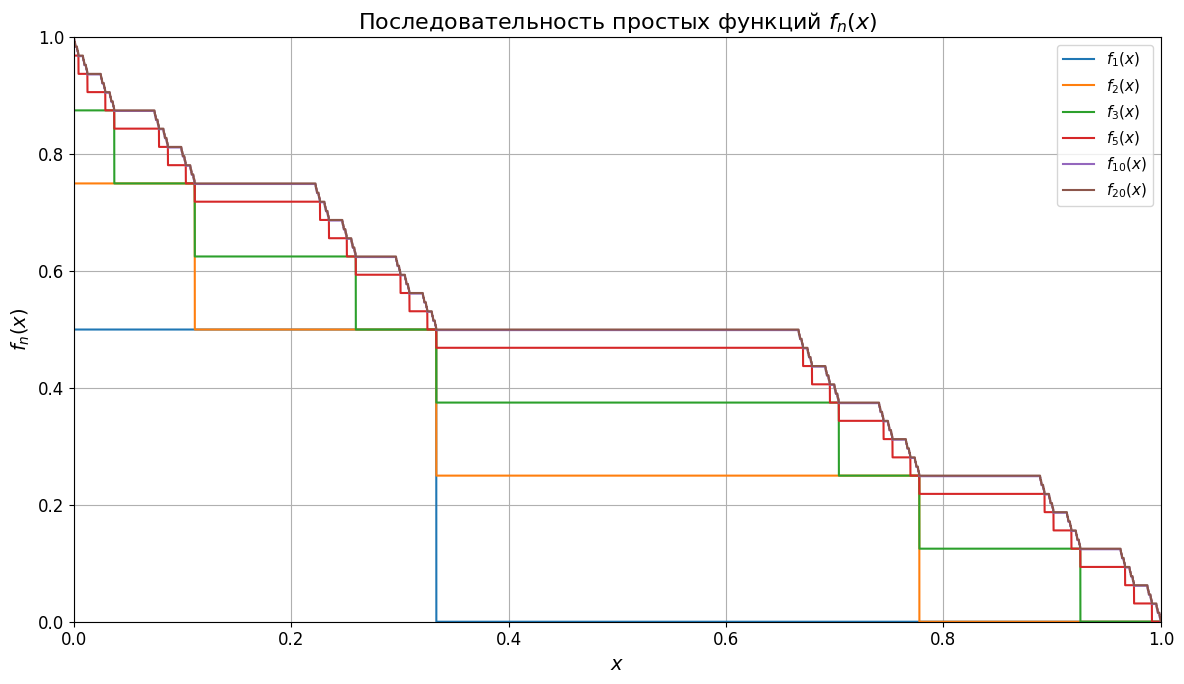

In [5]:
n_values: list[int] = [1, 2, 3, 5, 10, 20]

fig, ax = plt.subplots(figsize=(12, 7))

for n in n_values:
    y_values: npt.NDArray[np.float64] = f_n_vectorized(x_values, n)
    ax.plot(x_values, y_values, label=f"$f_{{{n}}}(x)$", linewidth=1.5)

ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$f_n(x)$", fontsize=14)
ax.set_title("Последовательность простых функций $f_n(x)$", fontsize=16)
ax.legend(loc="upper right", fontsize=11)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

---
## 6. Численное вычисление интегралов

### 6.1. Интеграл Лебега

Интеграл Лебега вычисляем методом прямоугольников:
$$\int_E f \, d\mu \approx \frac{1}{N} \sum_{i=1}^{N} f_n(x_i)$$

где $N$ — количество точек разбиения.

In [6]:
N_APPROX: int = 20

y_values: npt.NDArray[np.float64] = f_n_vectorized(x_values, N_APPROX)

integral_lebesgue: float = float(np.mean(y_values))

print(f"Интеграл Лебега (n={N_APPROX}):")
print(f"  Численный результат: {integral_lebesgue:.6f}")
print("  Теоретическое значение: 0.500000 (1/2)")
print(f"  Погрешность: {abs(integral_lebesgue - 0.5):.2e}")

Интеграл Лебега (n=20):
  Численный результат: 0.499999
  Теоретическое значение: 0.500000 (1/2)
  Погрешность: 9.54e-07


### 6.2. Интеграл Лебега-Стилтьеса

Интеграл Лебега-Стилтьеса вычисляем по формуле:
$$\int_E f \, dF \approx \sum_{i=1}^{N-1} f_n(x_i) \cdot (F(x_{i+1}) - F(x_i))$$

Теоретическое значение: $\frac{4}{3} \approx 1.333...$

In [7]:
F_values: npt.NDArray[np.float64] = F_vectorized(x_values)

dF: npt.NDArray[np.float64] = np.diff(F_values)

integral_stieltjes: float = float(np.sum(y_values[:-1] * dF))

THEORETICAL_STIELTJES: float = 4.0 / 3.0

print(f"Интеграл Лебега-Стилтьеса (n={N_APPROX}):")
print(f"  Численный результат: {integral_stieltjes:.6f}")
print(f"  Теоретическое значение: {THEORETICAL_STIELTJES:.6f} (4/3)")
print(f"  Погрешность: {abs(integral_stieltjes - THEORETICAL_STIELTJES):.2e}")

Интеграл Лебега-Стилтьеса (n=20):
  Численный результат: 1.333340
  Теоретическое значение: 1.333333 (4/3)
  Погрешность: 7.14e-06


---
## 7. Выводы

Численное моделирование подтвердило результаты аналитического этапа:

1. **Интеграл Лебега** сходится к теоретическому значению $\frac{1}{2}$ с высокой точностью
2. **Интеграл Лебега-Стилтьеса** сходится к теоретическому значению $\frac{4}{3}$ с высокой точностью
3. Последовательность простых функций $f_n(x)$ демонстрирует монотонную сходимость к предельной функции $f(x)$, что согласуется с теоремой Леви

Погрешности численного интегрирования обусловлены:
- Конечным числом точек разбиения ($N = 100\,000$)
- Конечным числом троичных разрядов ($n = 20$)
- Погрешностями арифметики с плавающей точкой